#Download do Dataset

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T000823Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dad26e7c150995e74f3f938548176d152f2bfc44273552b881c9124697dd6e89d4e5f259e188dfc21bf6ff925669a6c8a95fbace1de5f2fee02631a7cd15267b7c1051372cb741bdc85ecce3864ef69e3bc04286f08bda0b8a4e9456fb448c89bf43238d3c590cd0b05157969432efca232c9002e256637c55e2f35499700590e29332d00db88615aa2e0beaa2f66fdc1d95a3d1ddc220839487e8e94687be31b65940d313edacdb413507fbd06cdd7356acb6d83346ee7599a06752ed160583d2e15e9eeb5c5a8f09442ee019e57d68dbe864f3ccfc2914ba3aa561e68327a43331c02681e5df7fe23dc83364414e2eddbc2a897e352d734b2b49deb52254e80'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


# Instalação das bibliotecas

In [ ]:
!pip install pandas numpy matplotlib seaborn tqdm opencv-python torch torchsummary torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-1-6530242ea47a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'cuda'

# Carregamento do Dataset




In [ ]:
PATH = '/kaggle/input/eye-diseases-classification/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
3928,/kaggle/input/eye-diseases-classification/data...,3
3963,/kaggle/input/eye-diseases-classification/data...,3
1140,/kaggle/input/eye-diseases-classification/data...,1
3416,/kaggle/input/eye-diseases-classification/data...,3
1150,/kaggle/input/eye-diseases-classification/data...,1


## Gráfico de distribuição de dados



<ipython-input-17-47a2472f3634>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = "Set2")


<Axes: xlabel='outcome', ylabel='count'>

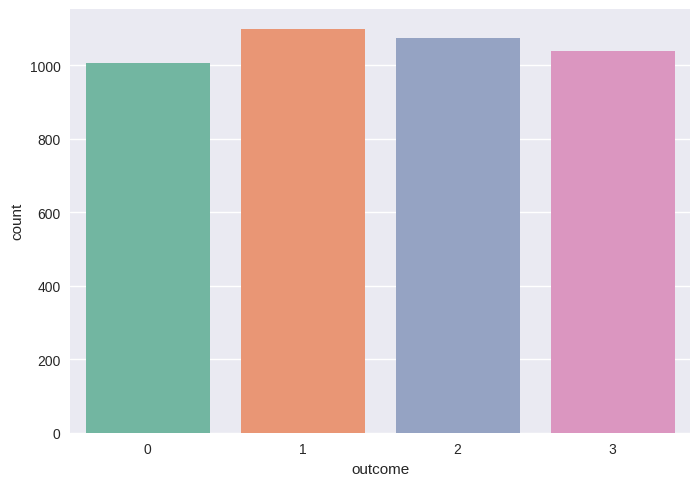

In [ ]:
sea.countplot(x = 'outcome', data = df, palette = "Set2"))

## Print de algumas imagens


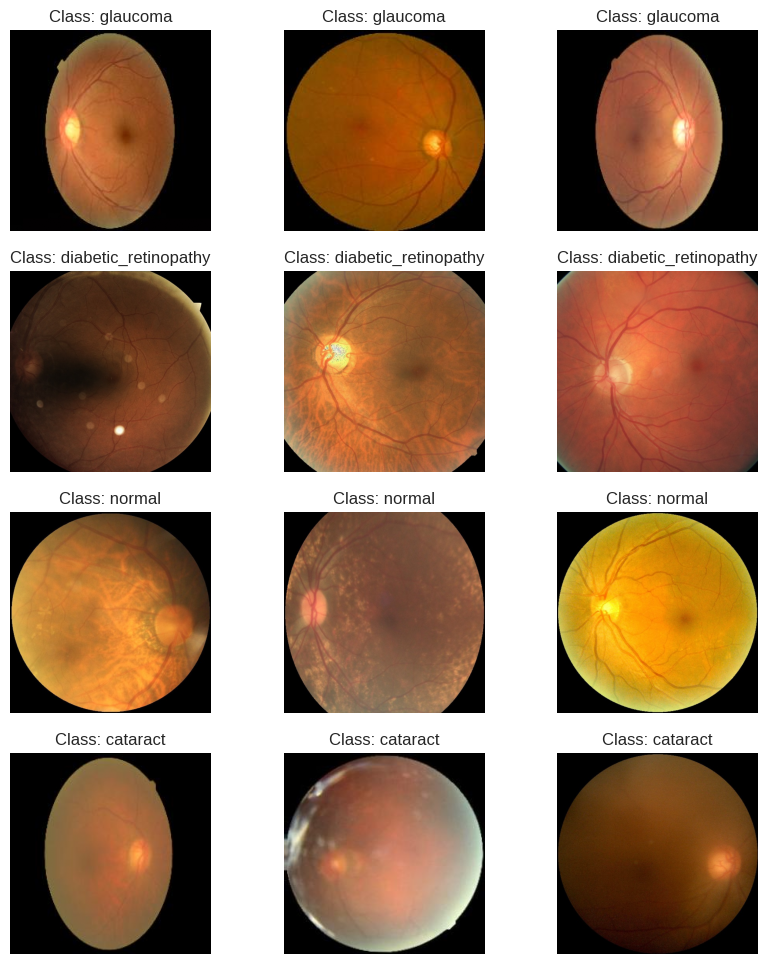

In [ ]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

# Pré-processamento

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

### Augmentation

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.5),
    transforms.RandomRotation(degrees = 15)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

###Dataloader

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

### Distruição do Dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

### Definição de parametros

In [ ]:
NUM_CLASSES = 4
BATCH_SIZE = 128

### Carregamento do Dataloader

In [ ]:
train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


# Modelo

In [ ]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.efficientnet_b0(pretrained = True) ### Definição do modelo

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

        self.additional_layer = nn.Linear(1280, 512) #Adicional layer

    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.additional_layer(x) #adicional layer
        x = self.block(x)
        return x


class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [ ]:
trainer = Trainer(train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.7MB/s]


## Resumo do Modelo

In [ ]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        (864)
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        (64)
|    |    └─SiLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 16, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 16, 112, 112]        (1,448)
|    └─Sequential: 2-3                        [-1, 24, 56, 56]          --
|    |    └─MBConv: 3-5                       [-1, 24, 56, 56]          (6,004)
|    |    └─MBConv: 3-6                       [-1, 24, 56, 56]          (10,710)
|    └─Sequential: 2-4                        [-1, 40, 28, 28]          --
|    |    └─MBConv: 3-7                       [-1, 40, 28, 28]          (1

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 112, 112]        (864)
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 112, 112]        (64)
|    |    └─SiLU: 3-3                         [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 16, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 16, 112, 112]        (1,448)
|    └─Sequential: 2-3                        [-1, 24, 56, 56]          --
|    |    └─MBConv: 3-5                       [-1, 24, 56, 56]          (6,004)
|    |    └─MBConv: 3-6                       [-1, 24, 56, 56]          (10,710)
|    └─Sequential: 2-4                        [-1, 40, 28, 28]          --
|    |    └─MBConv: 3-7                       [-1, 40, 28, 28]          (1

## Treinamento

In [ ]:
trainer.train(epochs = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 1.138 acc: 0.586] Val: [loss: 0.827 acc:0.740]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.730 acc: 0.730] Val: [loss: 0.614 acc:0.770]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.575 acc: 0.784] Val: [loss: 0.525 acc:0.808]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.551 acc: 0.789] Val: [loss: 0.497 acc:0.823]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.498 acc: 0.806] Val: [loss: 0.482 acc:0.820]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.470 acc: 0.815] Val: [loss: 0.456 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.453 acc: 0.818] Val: [loss: 0.475 acc:0.833]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.440 acc: 0.826] Val: [loss: 0.467 acc:0.834]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.425 acc: 0.832] Val: [loss: 0.458 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.408 acc: 0.843] Val: [loss: 0.447 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.397 acc: 0.846] Val: [loss: 0.435 acc:0.841]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 12] Train: [loss: 0.385 acc: 0.848] Val: [loss: 0.442 acc:0.831]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 13] Train: [loss: 0.380 acc: 0.851] Val: [loss: 0.477 acc:0.823]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 14] Train: [loss: 0.366 acc: 0.857] Val: [loss: 0.416 acc:0.844]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 15] Train: [loss: 0.360 acc: 0.855] Val: [loss: 0.414 acc:0.845]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 16] Train: [loss: 0.350 acc: 0.867] Val: [loss: 0.409 acc:0.853]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 17] Train: [loss: 0.341 acc: 0.873] Val: [loss: 0.403 acc:0.856]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 18] Train: [loss: 0.326 acc: 0.873] Val: [loss: 0.405 acc:0.839]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 19] Train: [loss: 0.331 acc: 0.870] Val: [loss: 0.384 acc:0.867]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 20] Train: [loss: 0.324 acc: 0.877] Val: [loss: 0.418 acc:0.841]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 21] Train: [loss: 0.322 acc: 0.873] Val: [loss: 0.384 acc:0.866]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 22] Train: [loss: 0.308 acc: 0.880] Val: [loss: 0.395 acc:0.842]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 23] Train: [loss: 0.294 acc: 0.889] Val: [loss: 0.393 acc:0.856]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 24] Train: [loss: 0.290 acc: 0.888] Val: [loss: 0.400 acc:0.856]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 25] Train: [loss: 0.290 acc: 0.892] Val: [loss: 0.380 acc:0.869]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 26] Train: [loss: 0.277 acc: 0.895] Val: [loss: 0.363 acc:0.874]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 27] Train: [loss: 0.292 acc: 0.889] Val: [loss: 0.371 acc:0.872]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 28] Train: [loss: 0.283 acc: 0.884] Val: [loss: 0.390 acc:0.862]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 29] Train: [loss: 0.288 acc: 0.891] Val: [loss: 0.366 acc:0.869]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 30] Train: [loss: 0.267 acc: 0.897] Val: [loss: 0.384 acc:0.862]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 31] Train: [loss: 0.282 acc: 0.888] Val: [loss: 0.363 acc:0.872]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 32] Train: [loss: 0.251 acc: 0.902] Val: [loss: 0.354 acc:0.874]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 33] Train: [loss: 0.274 acc: 0.894] Val: [loss: 0.378 acc:0.866]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 34] Train: [loss: 0.264 acc: 0.900] Val: [loss: 0.356 acc:0.879]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 35] Train: [loss: 0.245 acc: 0.908] Val: [loss: 0.349 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 36] Train: [loss: 0.253 acc: 0.900] Val: [loss: 0.381 acc:0.869]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 37] Train: [loss: 0.259 acc: 0.895] Val: [loss: 0.365 acc:0.871]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 38] Train: [loss: 0.242 acc: 0.907] Val: [loss: 0.360 acc:0.870]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 39] Train: [loss: 0.240 acc: 0.907] Val: [loss: 0.359 acc:0.869]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 40] Train: [loss: 0.239 acc: 0.908] Val: [loss: 0.335 acc:0.874]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 41] Train: [loss: 0.230 acc: 0.909] Val: [loss: 0.364 acc:0.864]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 42] Train: [loss: 0.244 acc: 0.907] Val: [loss: 0.364 acc:0.866]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 43] Train: [loss: 0.219 acc: 0.916] Val: [loss: 0.366 acc:0.874]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 44] Train: [loss: 0.223 acc: 0.915] Val: [loss: 0.366 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 45] Train: [loss: 0.220 acc: 0.917] Val: [loss: 0.380 acc:0.866]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 46] Train: [loss: 0.225 acc: 0.908] Val: [loss: 0.343 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 47] Train: [loss: 0.212 acc: 0.918] Val: [loss: 0.342 acc:0.878]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 48] Train: [loss: 0.214 acc: 0.917] Val: [loss: 0.389 acc:0.851]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 49] Train: [loss: 0.221 acc: 0.912] Val: [loss: 0.378 acc:0.861]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 50] Train: [loss: 0.209 acc: 0.918] Val: [loss: 0.331 acc:0.872]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 51] Train: [loss: 0.218 acc: 0.919] Val: [loss: 0.344 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 52] Train: [loss: 0.193 acc: 0.924] Val: [loss: 0.355 acc:0.870]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 53] Train: [loss: 0.199 acc: 0.924] Val: [loss: 0.347 acc:0.877]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 54] Train: [loss: 0.195 acc: 0.927] Val: [loss: 0.350 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 55] Train: [loss: 0.196 acc: 0.927] Val: [loss: 0.391 acc:0.874]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 56] Train: [loss: 0.198 acc: 0.920] Val: [loss: 0.338 acc:0.871]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 57] Train: [loss: 0.184 acc: 0.929] Val: [loss: 0.358 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 58] Train: [loss: 0.185 acc: 0.928] Val: [loss: 0.359 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 59] Train: [loss: 0.180 acc: 0.935] Val: [loss: 0.362 acc:0.888]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 60] Train: [loss: 0.184 acc: 0.928] Val: [loss: 0.318 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 61] Train: [loss: 0.194 acc: 0.926] Val: [loss: 0.350 acc:0.888]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 62] Train: [loss: 0.191 acc: 0.928] Val: [loss: 0.357 acc:0.875]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 63] Train: [loss: 0.191 acc: 0.920] Val: [loss: 0.298 acc:0.896]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 64] Train: [loss: 0.183 acc: 0.931] Val: [loss: 0.348 acc:0.877]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 65] Train: [loss: 0.184 acc: 0.930] Val: [loss: 0.343 acc:0.878]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 66] Train: [loss: 0.184 acc: 0.926] Val: [loss: 0.316 acc:0.889]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 67] Train: [loss: 0.160 acc: 0.937] Val: [loss: 0.362 acc:0.877]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 68] Train: [loss: 0.169 acc: 0.937] Val: [loss: 0.343 acc:0.888]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 69] Train: [loss: 0.168 acc: 0.935] Val: [loss: 0.332 acc:0.896]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 70] Train: [loss: 0.178 acc: 0.931] Val: [loss: 0.362 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 71] Train: [loss: 0.164 acc: 0.934] Val: [loss: 0.332 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 72] Train: [loss: 0.167 acc: 0.938] Val: [loss: 0.336 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 73] Train: [loss: 0.173 acc: 0.930] Val: [loss: 0.325 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 74] Train: [loss: 0.180 acc: 0.931] Val: [loss: 0.375 acc:0.866]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 75] Train: [loss: 0.163 acc: 0.934] Val: [loss: 0.325 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 76] Train: [loss: 0.160 acc: 0.938] Val: [loss: 0.329 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 77] Train: [loss: 0.174 acc: 0.929] Val: [loss: 0.318 acc:0.891]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 78] Train: [loss: 0.151 acc: 0.942] Val: [loss: 0.351 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 79] Train: [loss: 0.158 acc: 0.937] Val: [loss: 0.360 acc:0.881]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 80] Train: [loss: 0.153 acc: 0.938] Val: [loss: 0.346 acc:0.901]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 81] Train: [loss: 0.155 acc: 0.940] Val: [loss: 0.338 acc:0.896]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 82] Train: [loss: 0.155 acc: 0.941] Val: [loss: 0.361 acc:0.892]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 83] Train: [loss: 0.150 acc: 0.940] Val: [loss: 0.338 acc:0.896]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 84] Train: [loss: 0.159 acc: 0.935] Val: [loss: 0.337 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 85] Train: [loss: 0.150 acc: 0.945] Val: [loss: 0.387 acc:0.867]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 86] Train: [loss: 0.140 acc: 0.949] Val: [loss: 0.320 acc:0.896]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 87] Train: [loss: 0.137 acc: 0.950] Val: [loss: 0.362 acc:0.886]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 88] Train: [loss: 0.146 acc: 0.946] Val: [loss: 0.360 acc:0.880]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 89] Train: [loss: 0.138 acc: 0.951] Val: [loss: 0.338 acc:0.892]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 90] Train: [loss: 0.141 acc: 0.946] Val: [loss: 0.343 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 91] Train: [loss: 0.139 acc: 0.948] Val: [loss: 0.330 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 92] Train: [loss: 0.149 acc: 0.942] Val: [loss: 0.315 acc:0.890]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 93] Train: [loss: 0.141 acc: 0.949] Val: [loss: 0.345 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 94] Train: [loss: 0.132 acc: 0.948] Val: [loss: 0.348 acc:0.893]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 95] Train: [loss: 0.133 acc: 0.951] Val: [loss: 0.290 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 96] Train: [loss: 0.139 acc: 0.945] Val: [loss: 0.389 acc:0.863]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 97] Train: [loss: 0.135 acc: 0.947] Val: [loss: 0.320 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 98] Train: [loss: 0.141 acc: 0.944] Val: [loss: 0.314 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 99] Train: [loss: 0.120 acc: 0.954] Val: [loss: 0.369 acc:0.891]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 100] Train: [loss: 0.136 acc: 0.949] Val: [loss: 0.341 acc:0.879]


# Resultado do Treinamento
## Loss e Acurácia

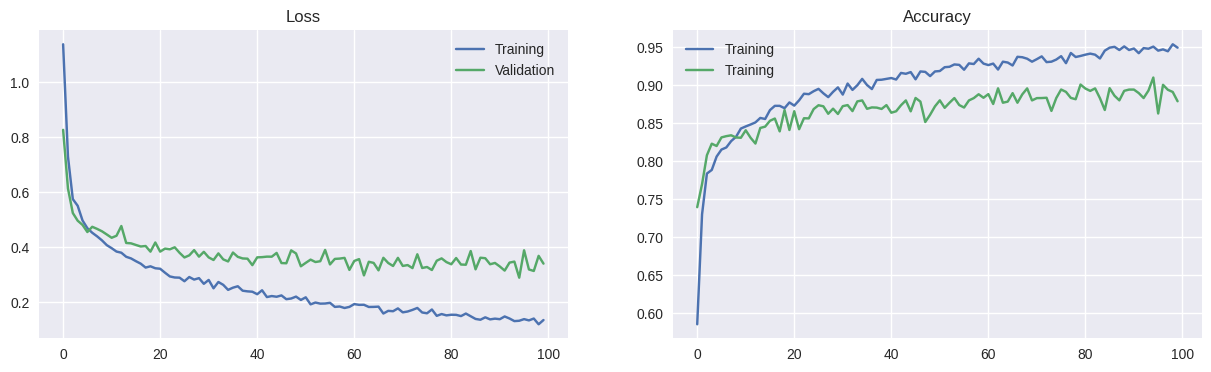

In [ ]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()



#Predição do dataset de Validação



In [ ]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

#Matriz de Confusão

Text(0.5, 1.0, 'Confusion Matrix')

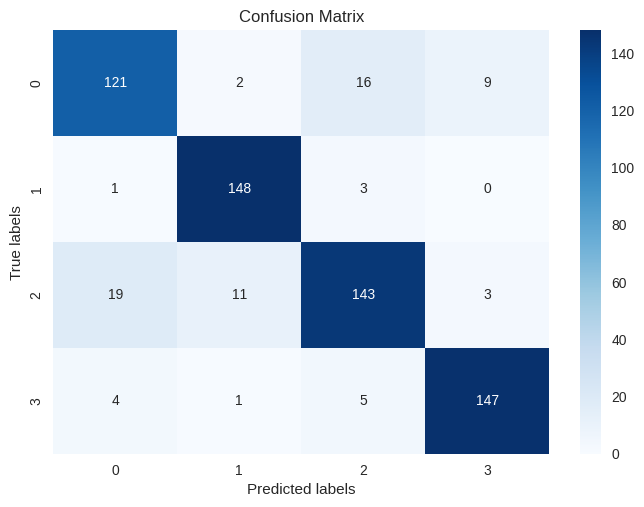

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys(), digi))

                      precision    recall  f1-score   support

            glaucoma       0.83      0.82      0.83       148
diabetic_retinopathy       0.91      0.97      0.94       152
              normal       0.86      0.81      0.83       176
            cataract       0.92      0.94      0.93       157

            accuracy                           0.88       633
           macro avg       0.88      0.89      0.88       633
        weighted avg       0.88      0.88      0.88       633

